In [1]:
import pandas as pd
import numpy as np

dagman_file = './exp3/exp3.dag.dagman.out'
log_file = './exp3/aldd_exp3.log'
num_termlines = 18
time_line=2
kb_to_gb = 1e-6
mb_to_gb = 1e-3

with open(dagman_file, 'r') as f:
    dag_content = f.readlines()
    
with open(log_file, 'r') as f:
    log_content = f.readlines()

In [2]:
job_names = [x.split('Node ')[1].split(' ')[0] for x in dag_content if 'Submitting HTCondor Node' in x]
job_names = np.unique(job_names)
    
job_info_list = []
for jname in job_names:
    # get job id assigned by condor
    line_idx = [i for i, x in enumerate(log_content) if jname in x][0]
    job_id = log_content[line_idx-1].split('(')[1].split(')')[0]

    # get job termination output and usage
    job_term = [i for i, x in enumerate(log_content) if (job_id in x) & ('terminated' in x)][-1]
    job_term = log_content[job_term:job_term+num_termlines]
    disk_usage = [i for i, x in enumerate(job_term) if 'Disk' in x][0]
    ram_usage = [i for i, x in enumerate(job_term) if 'Memory' in x][0]
    time_info = job_term[time_line].split(' ')[2][:-1]

    disk_usage = int(job_term[disk_usage].split()[3])
    ram_usage = int(job_term[ram_usage].split()[3])

    ram_usage *= mb_to_gb
    disk_usage *= kb_to_gb 

    hh, mm, ss = [int(x) for x in time_info.split(':')]
    total_hrs = hh + (mm / 60.0) + (ss / 3600.0)
    
    # job info
    rf_id = jname.split('+')[0].split('FILE_')[1]
    strategy = jname.split('HS_')[1].split('_TASK_')[0]
    task = jname.split('_TASK_')[1].split('_BATCH_')[0]
    iters = jname.split('_ITERS_')[1]
    strat_task_rfid = '{}_{}_{}'.format(strategy, task, rf_id)
    
    job_info_list.append([jname, strategy, task, rf_id, iters, strat_task_rfid, 
                          disk_usage, ram_usage, total_hrs, hh, mm, ss])

In [3]:
job_df = pd.DataFrame(data=job_info_list,
                      columns=['job_name', 'strategy', 'task', 'plate_id', 'iter', 'strategy_task_plate', 
                               'disk_usage (GB)', 'ram_usage (GB)', 'total_hours', 'hours', 'minutes', 'seconds'])

,disk_usage (GB),ram_usage (GB),total_hours
count,9416.000000,9416.000000,9416.000000
mean,23.424472,5.567657,23.911947
std,0.346148,3.341035,24.275069
min,4.473171,0.000000,0.000000
25%,23.201213,3.183000,4.857292
50%,23.210120,4.608000,12.637361
75%,23.664344,7.325000,41.145694
max,23.685953,19.532000,112.148056


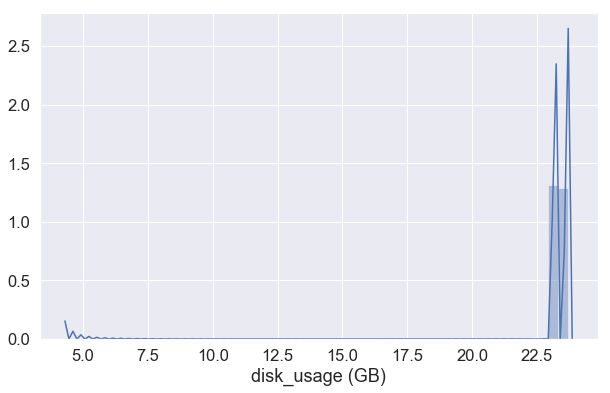

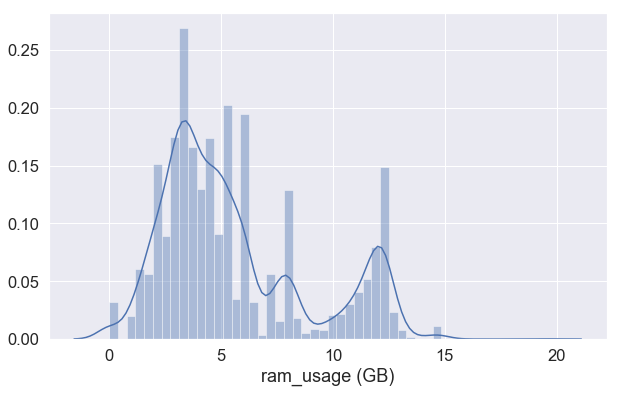

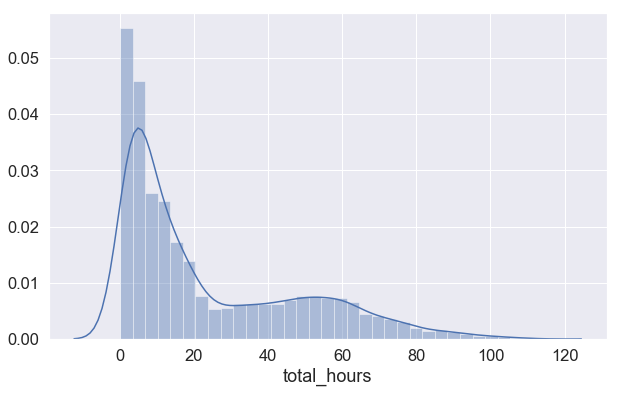

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=1.5)

def helper_agg(col):
    if col.name  in ['disk_usage (GB)', 'ram_usage (GB)']:
        return col.max()
    else:
        return col.sum()
        
group_cols = ['strategy_task_plate']
job_agg_df = job_df.groupby(group_cols).agg(helper_agg)
display(job_agg_df[['disk_usage (GB)', 'ram_usage (GB)', 'total_hours']].describe())

figsize=(10, 6)
plt.figure(figsize=figsize)
sns.distplot(job_agg_df['disk_usage (GB)'])
plt.figure(figsize=figsize)
sns.distplot(job_agg_df['ram_usage (GB)'])
plt.figure(figsize=figsize)
sns.distplot(job_agg_df['total_hours'])

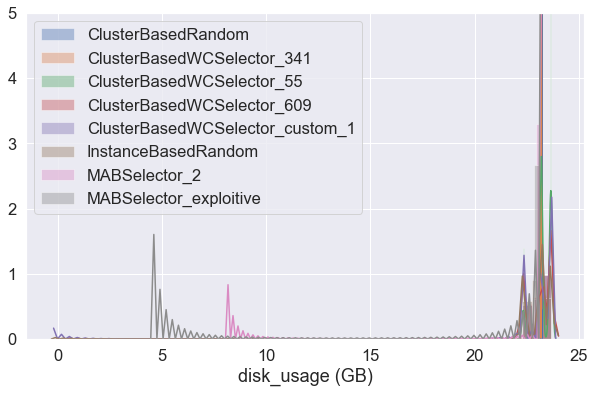

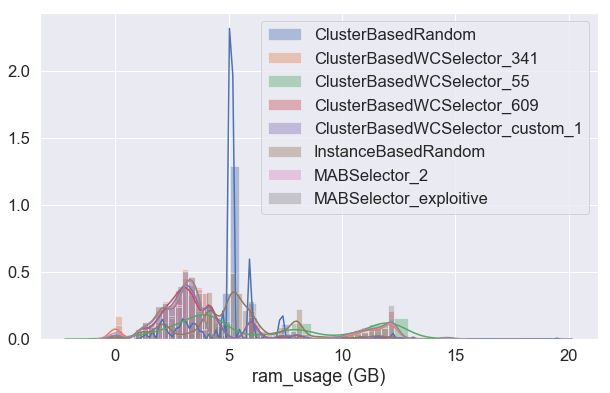

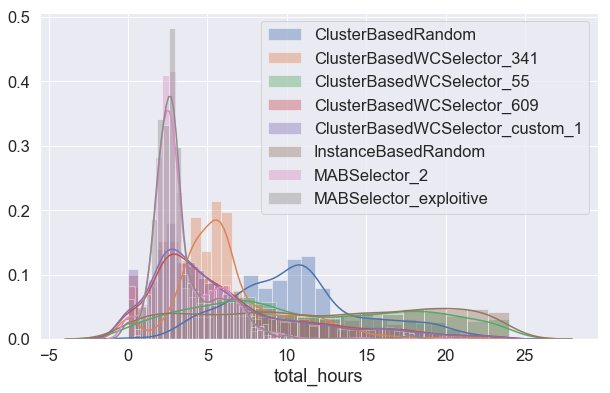

In [7]:
strategies = job_df['strategy'].unique()

for metric in ['disk_usage (GB)', 'ram_usage (GB)', 'total_hours']:
    figsize=(10, 6)
    plt.figure(figsize=figsize)
    for strategy in strategies:
        tmp_vals= job_df[job_df['strategy'] == strategy][metric].values
        sns.distplot(tmp_vals)
    if metric == 'disk_usage (GB)':
        plt.ylim([0, 5])
    plt.legend(strategies)
    plt.xlabel(metric)